## 1. Introduction


#### 🎯 Project Goal
> Build a machine learning system that can automatically detect fraudulent financial transactions based on transaction metadata.

#### 📊 Dataset Summary

- **Files**: 183 `.pkl` files, each representing transactions for a specific date.  
- **Combined Records**: (You’ll fill this after combining the files in Step 2).

  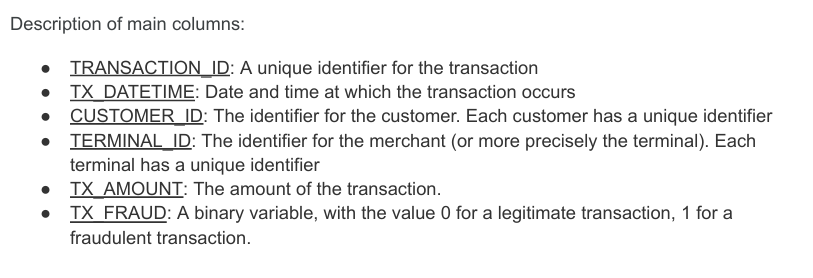
  

#### 🚨 Simulated Fraud Scenarios

1. **Amount-Based Fraud**

   
   - Any transaction with `TX_AMOUNT > 220` is marked as fraud (baseline pattern).  

3. **Terminal-Based Fraud**

   
   - 2 terminals chosen daily.  
   - All transactions from these terminals over the next 28 days are fraudulent.  

4. **Customer-Based Fraud**

   
   - 3 customers chosen daily.  
   - Over the next 14 days, ~33% of their transactions are marked fraudulent with `TX_AMOUNT` multiplied by 5.


## 2. Importing Libraries

In [41]:
# Core libraries
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Feature Engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Others
import joblib
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Optional: Set some seaborn style
sns.set(style="whitegrid")


## Data Loading

### 2.1 Define Dataset Path

In [2]:
data_path = "data" #Path of our dataset

### 2.2 Count Files

In [3]:
files = sorted([f for f in os.listdir(data_path) if f.endswith(".pkl")])
print("Total .pkl files found:", len(files))
print("First 3 files:", files[:3])

Total .pkl files found: 183
First 3 files: ['2018-04-01.pkl', '2018-04-02.pkl', '2018-04-03.pkl']


### 2.3 Read Sample File

In [4]:
sample_df = pd.read_pickle(os.path.join(data_path, files[0]))
print("Sample file shape:", sample_df.shape)
sample_df.head()

Sample file shape: (9488, 9)


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [5]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9488 entries, 0 to 9487
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TRANSACTION_ID     9488 non-null   int64         
 1   TX_DATETIME        9488 non-null   datetime64[ns]
 2   CUSTOMER_ID        9488 non-null   object        
 3   TERMINAL_ID        9488 non-null   object        
 4   TX_AMOUNT          9488 non-null   float64       
 5   TX_TIME_SECONDS    9488 non-null   object        
 6   TX_TIME_DAYS       9488 non-null   object        
 7   TX_FRAUD           9488 non-null   int64         
 8   TX_FRAUD_SCENARIO  9488 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 741.2+ KB


In [6]:
sample_df.isnull().sum()

TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

In [7]:
sample_df["TX_FRAUD"].value_counts()

TX_FRAUD
0    9485
1       3
Name: count, dtype: int64

### 2.4 Merge All Files

In [8]:
dfs = [pd.read_pickle(os.path.join(data_path, f)) for f in files]
full_df = pd.concat(dfs).sort_values("TX_DATETIME").reset_index(drop=True)
print("="*20)
print(" MERGING ALL FILES")
print("="*20)

 MERGING ALL FILES


### 2.5 Basic Info

In [9]:
full_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 120.4+ MB


In [11]:
full_df['TX_TIME_SECONDS'] = pd.to_numeric(full_df['TX_TIME_SECONDS'], errors='coerce')
full_df['TX_TIME_DAYS'] = pd.to_numeric(full_df['TX_TIME_DAYS'], errors='coerce')

In [12]:
print(full_df.dtypes[['TX_TIME_SECONDS', 'TX_TIME_DAYS']])

TX_TIME_SECONDS    int64
TX_TIME_DAYS       int64
dtype: object


In [13]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    int64         
 6   TX_TIME_DAYS       int64         
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 120.4+ MB


In [14]:
full_df["TX_FRAUD"].value_counts()

TX_FRAUD
0    1739474
1      14681
Name: count, dtype: int64

In [15]:
# Fraud scenario distribution
scenario_counts = full_df['TX_FRAUD_SCENARIO'].value_counts().sort_index()
print(scenario_counts)

TX_FRAUD_SCENARIO
0    1739474
1        973
2       9077
3       4631
Name: count, dtype: int64


In [16]:
# Extract date part only (YYYY-MM-DD)
full_df["TX_DATE"] = full_df["TX_DATETIME"].dt.date

# Number of unique days
unique_days = full_df["TX_DATE"].nunique()
print(f" Total number of unique days: {unique_days}")

 Total number of unique days: 183


## 3. Exploratory Data Analysis (EDA)

In [17]:
# Summary stats for categorical features
print("\nCategorical Features Summary:")
print(full_df[['CUSTOMER_ID', 'TERMINAL_ID']].describe(include='object'))


Categorical Features Summary:
        CUSTOMER_ID  TERMINAL_ID
count       1754155      1754155
unique         4990        10000
top             382         4018
freq            767          376


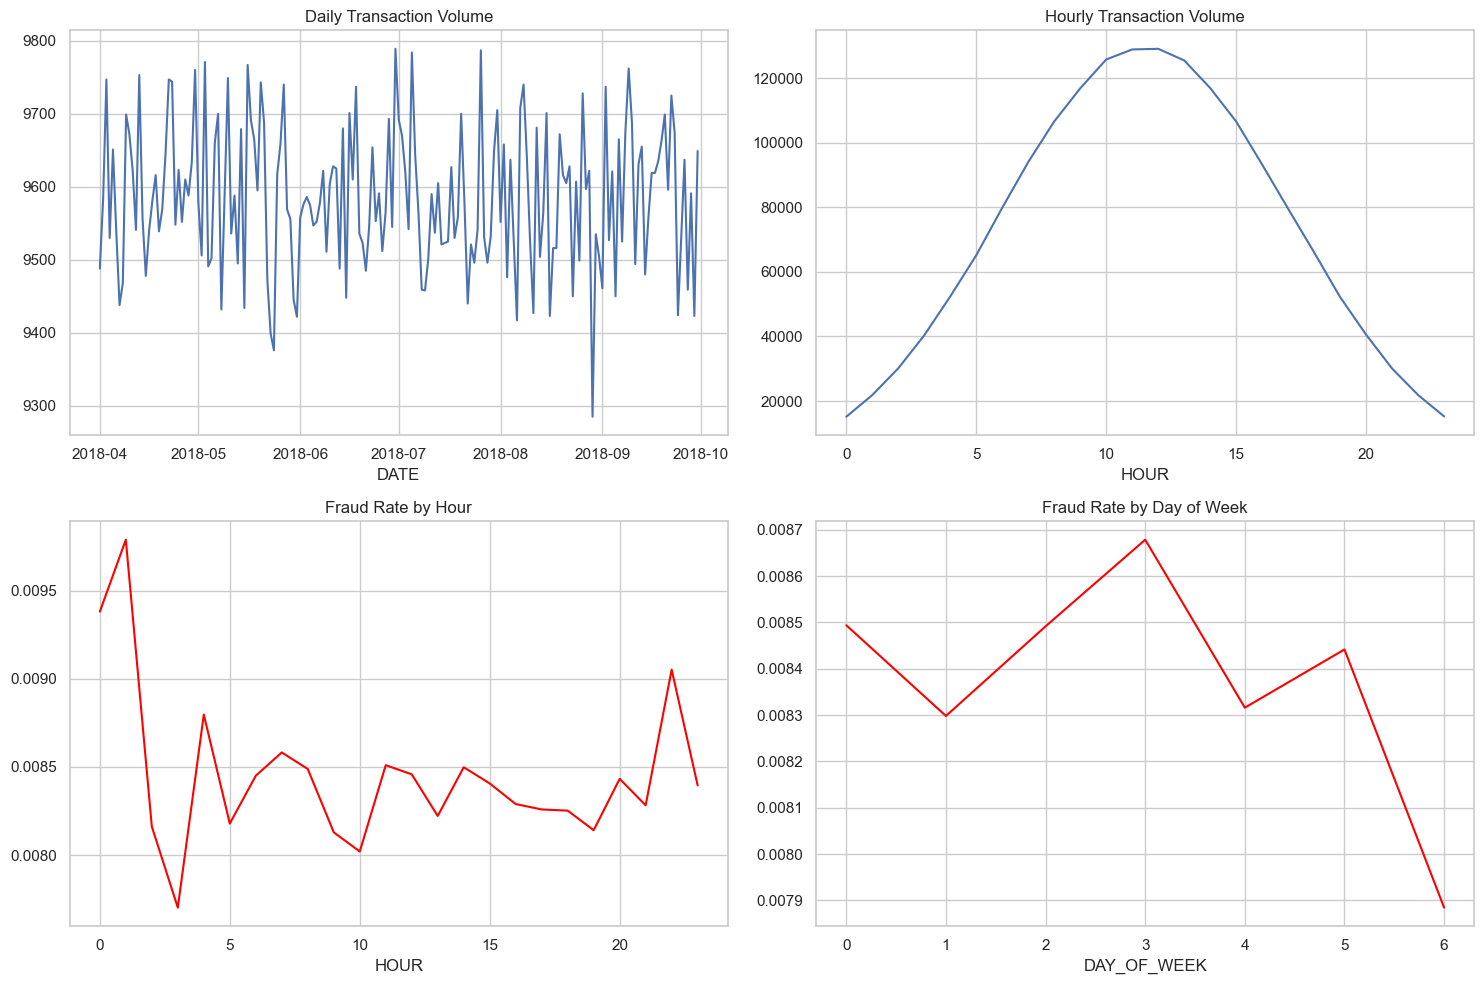

In [18]:
# Extract time-based features
full_df['HOUR'] = full_df['TX_DATETIME'].dt.hour
full_df['DAY_OF_WEEK'] = full_df['TX_DATETIME'].dt.dayofweek  # Monday=0, Sunday=6
full_df['DATE'] = full_df['TX_DATETIME'].dt.date

# Transaction volume over time
daily_counts = full_df.groupby('DATE').size()
hourly_counts = full_df.groupby('HOUR').size()

# Fraud rate by time
fraud_by_hour = full_df.groupby('HOUR')['TX_FRAUD'].mean()
fraud_by_day = full_df.groupby('DAY_OF_WEEK')['TX_FRAUD'].mean()

# Plot temporal patterns
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
daily_counts.plot(ax=ax[0,0], title='Daily Transaction Volume')
hourly_counts.plot(ax=ax[0,1], title='Hourly Transaction Volume')
fraud_by_hour.plot(ax=ax[1,0], title='Fraud Rate by Hour', color='red')
fraud_by_day.plot(ax=ax[1,1], title='Fraud Rate by Day of Week', color='red')
plt.tight_layout()
plt.show()


Transactions > $220: 3258
Fraud rate in high amounts: 100.00%


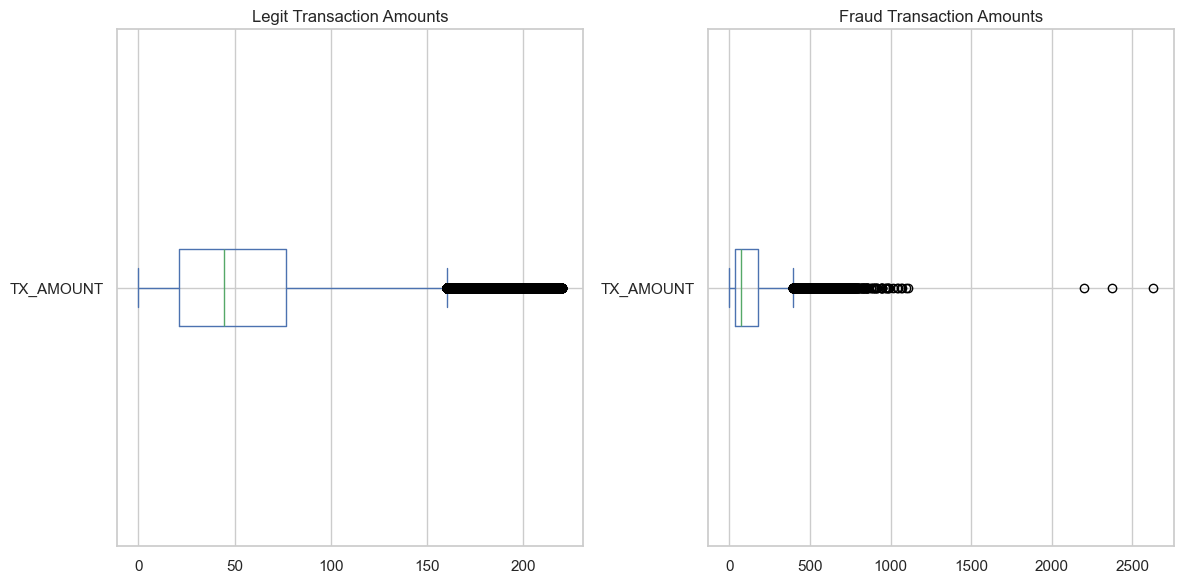

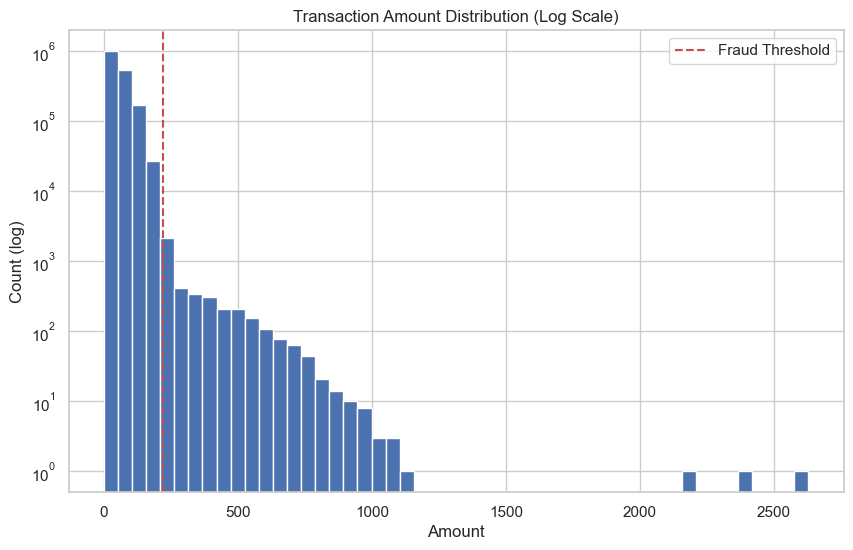

In [19]:
# Amount distribution by fraud status
plt.figure(figsize=(12, 6))
plt.subplot(121)
full_df[full_df['TX_FRAUD']==0]['TX_AMOUNT'].plot(kind='box', vert=False)
plt.title('Legit Transaction Amounts')
plt.subplot(122)
full_df[full_df['TX_FRAUD']==1]['TX_AMOUNT'].plot(kind='box', vert=False)
plt.title('Fraud Transaction Amounts')
plt.tight_layout()

# Verify fraud scenario 1 (Amount > 220)
high_amount_fraud = full_df[full_df['TX_AMOUNT'] > 220]
print(f"\nTransactions > $220: {len(high_amount_fraud)}")
print(f"Fraud rate in high amounts: {high_amount_fraud['TX_FRAUD'].mean():.2%}")

# Plot amount distributions
plt.figure(figsize=(10, 6))
full_df['TX_AMOUNT'].hist(bins=50, log=True)
plt.axvline(x=220, color='r', linestyle='--', label='Fraud Threshold')
plt.title('Transaction Amount Distribution (Log Scale)')
plt.xlabel('Amount')
plt.ylabel('Count (log)')
plt.legend()
plt.show()

### 3.1  Fraud vs Legit: Count & Ratio

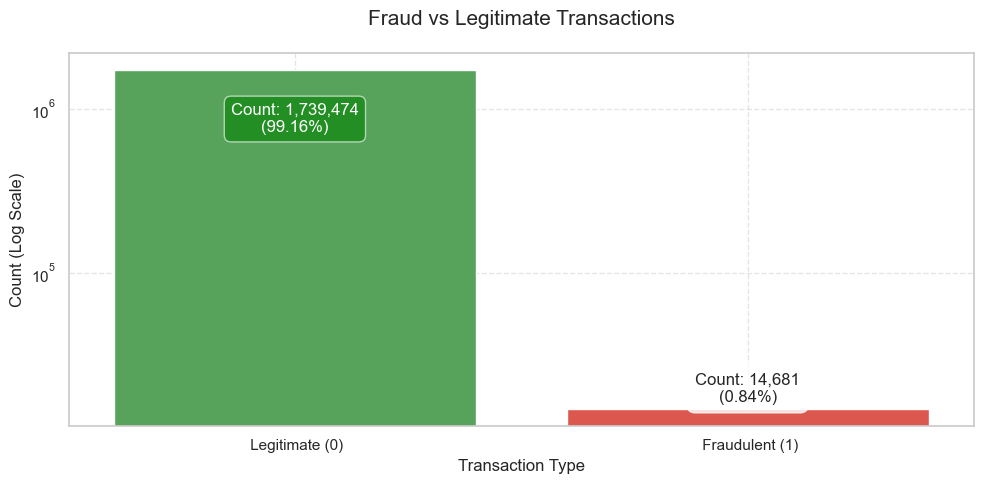

In [20]:
# Count values and percentage
fraud_counts = full_df["TX_FRAUD"].value_counts().sort_index()
total = fraud_counts.sum()
percentages = (fraud_counts / total * 100).round(2)

# Bar colors
colors = ['#4CAF50', '#F44336']  # Green for legit, red for fraud

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette=colors)

# Annotate inside for Legit, above for Fraud
for i, (count, pct) in enumerate(zip(fraud_counts.values, percentages.values)):
    if i == 0:  # Legit - inside the bar
        ax.text(i, count * 0.5,
                f'Count: {count:,}\n({pct}%)',
                ha='center', va='center',
                color='white', fontsize=12,
                bbox=dict(facecolor='green', alpha=0.6, boxstyle='round,pad=0.4'))
    else:  # Fraud - above the bar
        ax.text(i, count + 1000,
                f'Count: {count:,}\n({pct}%)',
                ha='center', va='bottom',
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# Log scale to handle imbalance
plt.yscale("log")

# Style
plt.title("Fraud vs Legitimate Transactions", fontsize=15, pad=20)
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Count (Log Scale)", fontsize=12)
plt.xticks([0, 1], [" Legitimate (0)", " Fraudulent (1)"], fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 3.2: TX_AMOUNT Distribution Analysis 

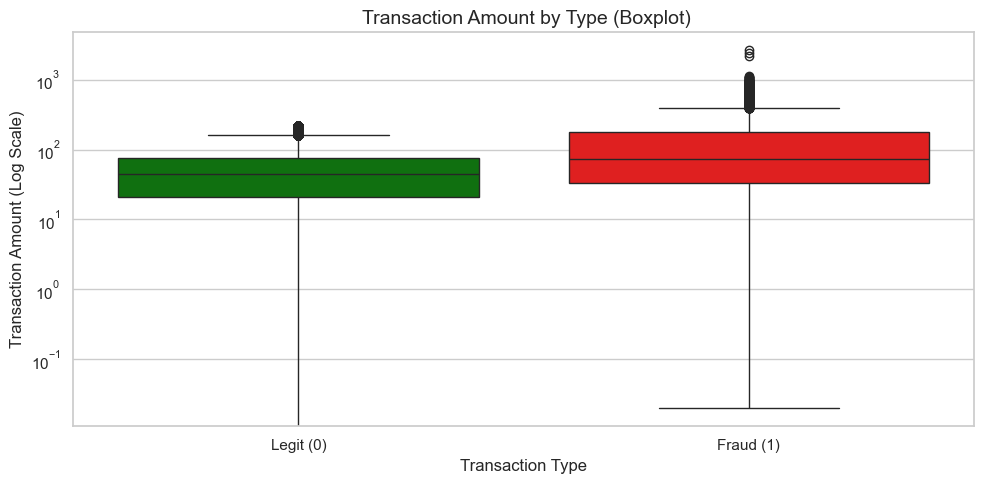

In [21]:
# Set style
sns.set_style("whitegrid")

# 1. Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=full_df, x="TX_FRAUD", y="TX_AMOUNT", palette=["green", "red"])
plt.yscale("log")  # Log scale to reduce effect of outliers
plt.title(" Transaction Amount by Type (Boxplot)", fontsize=14)
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Amount (Log Scale)")
plt.xticks([0, 1], ["Legit (0)", "Fraud (1)"])
plt.tight_layout()
plt.show()


### 3.3 Time-based Fraud Patterns

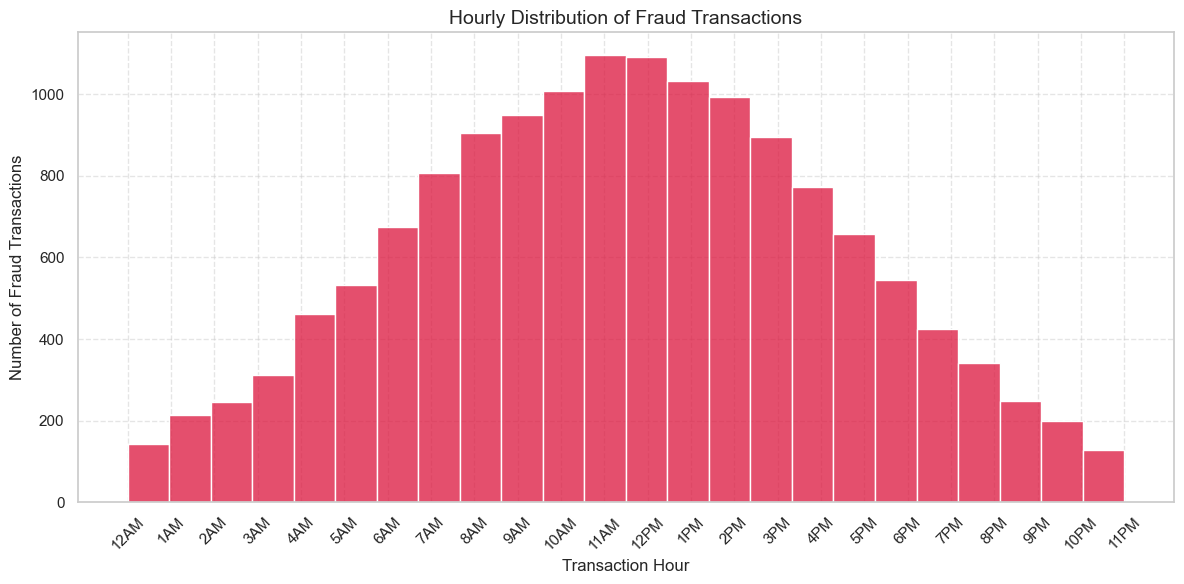

In [22]:
fraud_df = full_df[full_df["TX_FRAUD"] == 1]

# Create TX_HOUR if not already extracted
fraud_df["TX_HOUR"] = fraud_df["TX_DATETIME"].dt.hour

# AM/PM Labels
hour_labels = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
               '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(data=fraud_df, x="TX_HOUR", bins=24, color="crimson")

plt.title("Hourly Distribution of Fraud Transactions", fontsize=14)
plt.xlabel("Transaction Hour", fontsize=12)
plt.ylabel("Number of Fraud Transactions", fontsize=12)
plt.xticks(ticks=range(24), labels=hour_labels, rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



### 3.4 Terminal-wise Fraud Trend

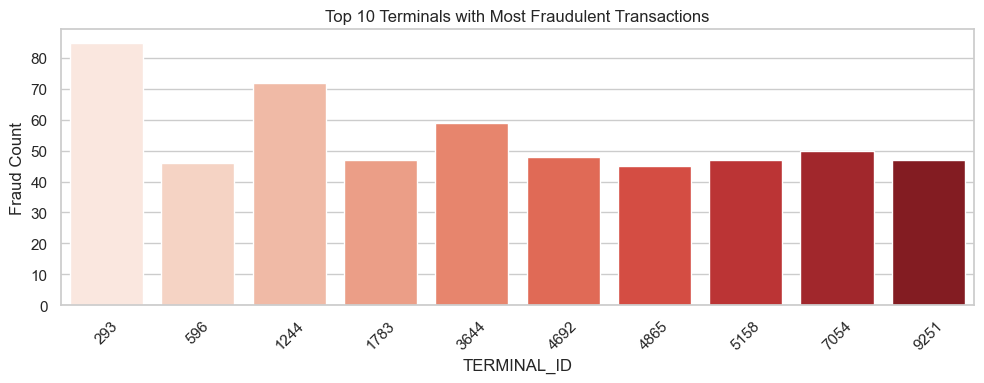

In [23]:
# Top 10 terminals with most frauds
top_fraud_terminals = full_df[full_df['TX_FRAUD'] == 1]['TERMINAL_ID'].value_counts().head(10)

plt.figure(figsize=(10,4))
sns.barplot(x=top_fraud_terminals.index, y=top_fraud_terminals.values, palette='Reds')
plt.title("Top 10 Terminals with Most Fraudulent Transactions")
plt.xlabel("TERMINAL_ID")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 ### 3.5 Terminal-wise Fraud Rate (EDA)

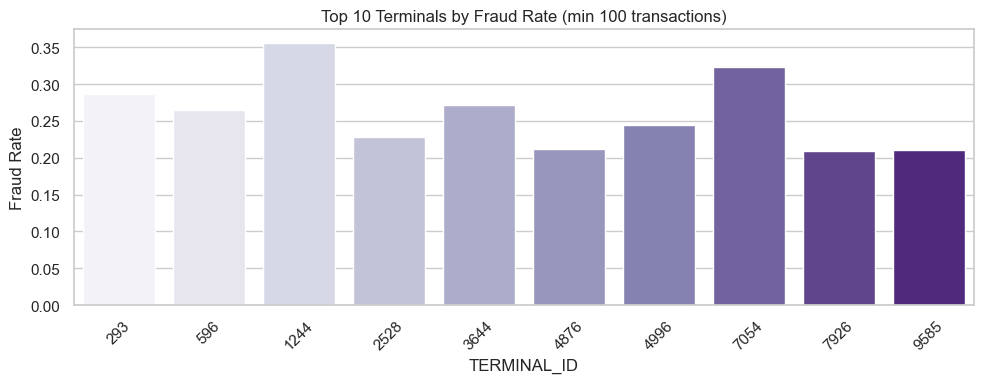

In [24]:
# Group by terminal
terminal_stats = full_df.groupby('TERMINAL_ID')['TX_FRAUD'].agg(['count', 'sum'])

# Add fraud rate
terminal_stats['FRAUD_RATE'] = terminal_stats['sum'] / terminal_stats['count']

# Top 10 terminals by highest fraud rate (with minimum 100 transactions for reliability)
top_fraud_rate = terminal_stats[terminal_stats['count'] > 100].sort_values('FRAUD_RATE', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,4))
sns.barplot(x=top_fraud_rate.index, y=top_fraud_rate['FRAUD_RATE'], palette='Purples')
plt.title("Top 10 Terminals by Fraud Rate (min 100 transactions)")
plt.xlabel("TERMINAL_ID")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.4: Customer-wise Spending Trend

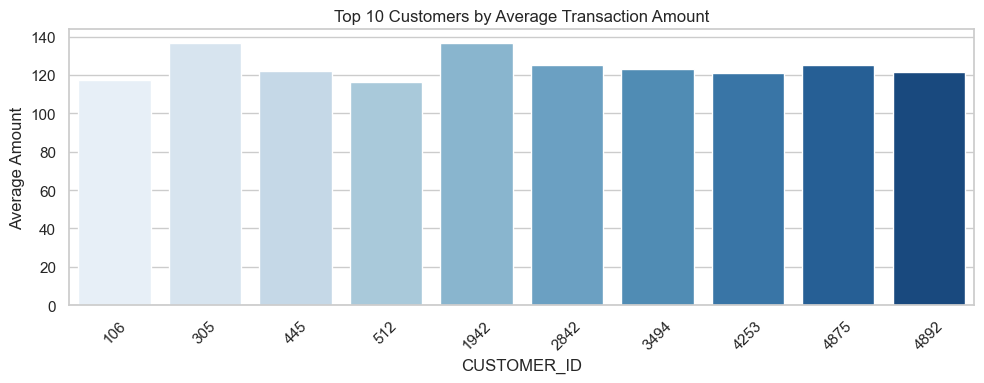

In [25]:
# Top 10 customers by average spend
customer_avg_amount = full_df.groupby('CUSTOMER_ID')['TX_AMOUNT'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,4))
sns.barplot(x=customer_avg_amount.index, y=customer_avg_amount.values, palette='Blues')
plt.title("Top 10 Customers by Average Transaction Amount")
plt.xlabel("CUSTOMER_ID")
plt.ylabel("Average Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 ### 3.5: Transaction count per customer

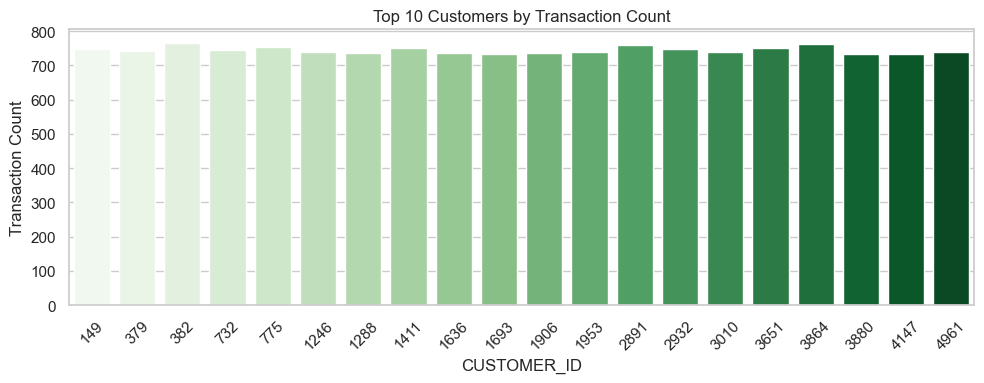

In [26]:
# Top 10 customers by number of transactions
customer_tx_count = full_df['CUSTOMER_ID'].value_counts().head(20)

plt.figure(figsize=(10,4))
sns.barplot(x=customer_tx_count.index, y=customer_tx_count.values, palette='Greens')
plt.title("Top 10 Customers by Transaction Count")
plt.xlabel("CUSTOMER_ID")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Feature Engineering

### 4.1: CUSTOMER_TX_COUNT_1DAY & AMOUNT_1DAY

In [27]:
# First sort the dataframe
full_df = full_df.sort_values(['CUSTOMER_ID', 'TX_DATETIME'])

# Set TX_DATETIME as index temporarily for rolling
full_df.set_index('TX_DATETIME', inplace=True)

# Group by CUSTOMER_ID
customer_groups = full_df.groupby('CUSTOMER_ID')

# Apply rolling window of 1 day
rolling_features = customer_groups['TX_AMOUNT'].rolling('1D').agg(['count', 'sum'])

# Rename columns
rolling_features.columns = ['CUSTOMER_TX_COUNT_1DAY', 'CUSTOMER_TX_AMOUNT_1DAY']

# Reset index and merge back to main df
rolling_features = rolling_features.reset_index()
full_df = full_df.reset_index()  # restore TX_DATETIME as column

# Join features back
full_df = full_df.merge(rolling_features, on=['CUSTOMER_ID', 'TX_DATETIME'], how='left')


### 4.2 Terminal Fraud History Features

In [28]:
# Sort by TERMINAL_ID and TX_DATETIME
full_df = full_df.sort_values(['TERMINAL_ID', 'TX_DATETIME'])

# Set TX_DATETIME as index
full_df.set_index('TX_DATETIME', inplace=True)

# Group by terminal
terminal_groups = full_df.groupby('TERMINAL_ID')

# Rolling 1-day window: count and fraud count
terminal_stats = terminal_groups['TX_FRAUD'].rolling('1D').agg(['count', 'sum'])

# Rename
terminal_stats.columns = ['TERMINAL_TX_COUNT_1DAY', 'TERMINAL_FRAUD_COUNT_1DAY']

# Reset index & merge
terminal_stats = terminal_stats.reset_index()
full_df = full_df.reset_index()
full_df = full_df.merge(terminal_stats, on=['TERMINAL_ID', 'TX_DATETIME'], how='left')


 ### 4.3: Customer Spending Deviation Feature

In [29]:
# Sort by CUSTOMER_ID and TX_DATETIME
full_df = full_df.sort_values(['CUSTOMER_ID', 'TX_DATETIME'])

# Set datetime as index
full_df.set_index('TX_DATETIME', inplace=True)

# Group by customer and rolling mean over 1 day
customer_avg = full_df.groupby('CUSTOMER_ID')['TX_AMOUNT'].rolling('1D').mean().reset_index()
customer_avg.rename(columns={'TX_AMOUNT': 'CUSTOMER_AVG_AMOUNT_1DAY'}, inplace=True)

# Reset index and merge back
full_df = full_df.reset_index()
full_df = full_df.merge(customer_avg, on=['CUSTOMER_ID', 'TX_DATETIME'], how='left')

# Create ratio column
full_df['AMOUNT_OVER_AVG'] = full_df['TX_AMOUNT'] / (full_df['CUSTOMER_AVG_AMOUNT_1DAY'] + 1e-3)  # avoid /0


## 5: Data Preprocessing

### 5.1: Train-Test Split

In [30]:
# Sort by datetime for time-based split
full_df = full_df.sort_values('TX_DATETIME')

# Get split index (e.g., 80% train)
split_index = int(0.8 * len(full_df))
train_df = full_df.iloc[:split_index]
test_df = full_df.iloc[split_index:]

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 1404820
Test size: 351205


 ### 5.2: Handle Class Imbalance

In [31]:
from sklearn.utils import resample

# Separate fraud and legit in train set
fraud_df = train_df[train_df['TX_FRAUD'] == 1]
legit_df = train_df[train_df['TX_FRAUD'] == 0]

# Downsample legit to match fraud count * 5 (adjustable ratio)
legit_downsampled = resample(legit_df,
                             replace=False,
                             n_samples=len(fraud_df) * 5,
                             random_state=42)

# Combine and shuffle
balanced_train_df = pd.concat([fraud_df, legit_downsampled])
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42)

print("Balanced train fraud:", balanced_train_df['TX_FRAUD'].sum())
print("Balanced train total:", len(balanced_train_df))


Balanced train fraud: 11566
Balanced train total: 69396


### 5.3: Feature Scaling

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# List of numeric columns to scale
scale_cols = ['TX_AMOUNT', 'TX_TIME_SECONDS']

# Convert TX_TIME_SECONDS to numeric (if it's not already)
balanced_train_df['TX_TIME_SECONDS'] = pd.to_numeric(balanced_train_df['TX_TIME_SECONDS'], errors='coerce')
test_df['TX_TIME_SECONDS'] = pd.to_numeric(test_df['TX_TIME_SECONDS'], errors='coerce')

# Fit only on train, transform both train and test
balanced_train_df[scale_cols] = scaler.fit_transform(balanced_train_df[scale_cols])
test_df[scale_cols] = scaler.transform(test_df[scale_cols])


## 6. Model Building

### Random Forest

In [34]:
# Selected Features (based on EDA and relevance)
feature_cols = [
    'TX_AMOUNT',
    'TX_TIME_SECONDS',
    'HOUR',
    'DAY_OF_WEEK',
    'CUSTOMER_TX_COUNT_1DAY',
    'CUSTOMER_TX_AMOUNT_1DAY',
    'TERMINAL_TX_COUNT_1DAY',
    'TERMINAL_FRAUD_COUNT_1DAY',
    'CUSTOMER_AVG_AMOUNT_1DAY',
    'AMOUNT_OVER_AVG'
]

target = 'TX_FRAUD'


In [38]:
# Define input and output
X_train = balanced_train_df[feature_cols]
y_train = balanced_train_df['TX_FRAUD']

X_test = test_df[feature_cols]
y_test = test_df[target]

print(" Features and target separated successfully.")

 Features and target separated successfully.


In [39]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',  # handles class imbalance
    random_state=42,
    n_jobs=-1  # use all processors
)

# Train the model
rf_model.fit(X_train, y_train)

print(" Random Forest Model trained successfully.")

 Random Forest Model trained successfully.


In [40]:
y_pred = rf_model.predict(X_test)

# Predict probabilities for ROC AUC
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print("\nROC AUC Score:", round(roc_score, 4))

Confusion Matrix:
 [[346931   1128]
 [     3   3143]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    348059
           1       0.74      1.00      0.85      3146

    accuracy                           1.00    351205
   macro avg       0.87      1.00      0.92    351205
weighted avg       1.00      1.00      1.00    351205


ROC AUC Score: 0.9999


In [43]:

# Save the model
joblib.dump(rf_model, 'fraud_detection_model.pkl')

# Save the scaler too (important for consistent scaling during prediction)
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']